# Import tabular data

The tabular data is imported. This contains information on whether several elements are present in the image, such as blur, a human, a group, etc. Also the pawpularity score of the training data is in the table. For the test data only the image ID and the features are in the table. There is also a sample submission table, which contains the pawpularity score for the test data.

In [12]:
import pandas as pd
from os import chdir, listdir
import zipfile
import os


import matplotlib.pyplot as plt
import cv2
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing
from tensorflow.keras.losses import MeanSquaredError


In [2]:

!wget --no-check-certificate \
    "https://github.com/ilsefeenstra/Fitgirls0011/archive/refs/heads/main.zip" \
    -O "/tmp/pawpularity_data.zip"

zip_ref = zipfile.ZipFile('/tmp/pawpularity_data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2022-01-12 14:12:04--  https://github.com/ilsefeenstra/Fitgirls0011/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ilsefeenstra/Fitgirls0011/zip/refs/heads/main [following]
--2022-01-12 14:12:04--  https://codeload.github.com/ilsefeenstra/Fitgirls0011/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/pawpularity_data.zip’

/tmp/pawpularity_da     [           <=>      ] 983.85M  21.9MB/s    in 46s     

2022-01-12 14:12:50 (21.5 MB/s) - ‘/tmp/pawpularity_data.zip’ saved [1031643754]



In [3]:
# import the CSV tables
csv_train_data = pd.read_csv("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/train.csv")
csv_test_data = pd.read_csv("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/test.csv")
sample_submission = pd.read_csv("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/sample_submission.csv")
csv_train_data.head()

# drop rows with missing values (if NaN values are in dataframe)
# no missing values present, so no samples dropped
csv_train_data.dropna()

# scale the pawpularity score to numbers between 0 and 1
csv_train_data['Pawpularity'] = csv_train_data['Pawpularity'] / 100
sample_submission['Pawpularity'] = sample_submission['Pawpularity'] / 100

In [4]:
csv_train_data.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,0.63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,0.42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,0.28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,0.15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,0.72


# Import image data


In [5]:
def reshape_images(path, n):
    """
    This function returns a list of images, which are reshaped to 64 x 64 
    and a list with the names of the images.
    """
    
    # set the current path
    chdir(path)
    
    # preset the lists
    images = []
    image_names = []
    
    # go over all the files in the path
    for i in listdir():
        
        # get the name of the image, without .jpg
        image_names.append(i[:-4])
        
        # get the image and reshape to n x n
        file = cv2.imread(i)
        file = cv2.resize(file,(n, n), interpolation=cv2.INTER_AREA)
        
        # rescale the pixels and store in the list
        images.append(file/255)
        
    return images, image_names

train_imgs, train_names = reshape_images("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/train", 64)
test_imgs, test_names = reshape_images("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/test", 64)

In [15]:
# make numpy array of images
train_imgs_array = np.array(train_imgs)
test_imgs_array = np.array(test_imgs)

# Combine tabular data with images

In [6]:
def merge_images(data, images, names):
    """
    This function sorts the dataframe of the csv data according to the image names.
    """
    
    data_sorted = pd.DataFrame()

    for img, name in zip(images, names):
        location = data[data['Id'] == name].index[0]
        data_sorted = data_sorted.append([data.loc[location]])
        
    return data_sorted

train_data_sorted = merge_images(csv_train_data, train_imgs, train_names)
test_data_sorted = merge_images(csv_test_data, test_imgs, test_names)
sample_submission_sorted = merge_images(sample_submission, test_imgs, test_names)

# Processing tabular data

In [7]:
# Select x-values (the 12 input features) from training data
x_train_tabular = train_data_sorted.iloc[:,1:13].to_numpy()

# Select y-values (pawpularity) from training data
y_train = train_data_sorted.iloc[:,13].to_numpy()

# Select x-values (12 input features) from testing data
x_test_tabular = test_data_sorted.iloc[:,1:13].to_numpy()

# Select y-values (pawpularity) from testing data
y_test = sample_submission_sorted.iloc[:,1].to_numpy()

In [8]:
def build_neural_net(input_size, hidden_nodes):
    """
    Build neural network with an input size and a hidden layer with a number of hidden nodes.
    """
    # Create a sequential model object
    model = models.Sequential()

    # Create the hidden layer with relu activations
    model.add(layers.Dense(units=hidden_nodes, activation='relu', input_shape=(input_size,)))
    
    # Create the output layer with 1 regression output unit
    model.add(layers.Dense(units=1))
    
    # Compile the network with the appropriate loss function
    model.compile(loss=MeanSquaredError())
    
    return model

# Create neural network for tabular data and get summary of model
tabular_NN = build_neural_net(12, 20)
tabular_NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                260       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
446/446 [==============================] - 3s 3ms/step - loss: 0.0500 - val_loss: 0.0443
Epoch 2/20
446/446 [==============================] - 1s 3ms/step - loss: 0.0436 - val_loss: 0.0437
Epoch 3/20
446/446 [==============================] - 1s 3ms/step - loss: 0.0432 - val_loss: 0.0435
Epoch 4/20
446/446 [==============================] - 1s 3ms/step - loss: 0.0430 - val_loss: 0.0435
Epoch 5/20
446/446 [==============================] - 1s 3ms/step - loss: 0.0428 - val_loss: 0.0436
Epoch 6/20
446/446 [==============================] - 1s 3ms/step - loss: 0.0428 - val_loss: 0.0430
Epoch 7/20
446/446 [==============================] - 1s 3ms/step - loss: 0.0427 - val_loss: 0.0429
Epoch 8/20
446/446 [==============================] - 1s 3ms/step - loss: 0.0426 - val_loss: 0.0426
Epoch 9/20
446/446 [==============================] - 1s 3ms/step - loss: 0.0425 - val_loss: 0.0428
Epoch 10/20
446/446 [==============================] - 1s 3ms/step - loss: 0.0426 - val_loss: 0.0430

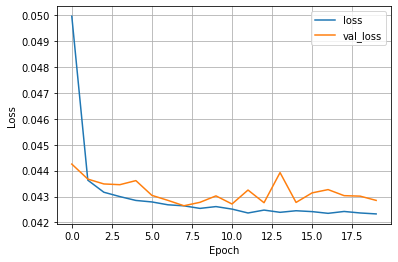

In [9]:
# Part of code from: https://www.tensorflow.org/tutorials/keras/regression

# Train our model
history = tabular_NN.fit(x_train_tabular, y_train, batch_size=20, epochs=20, validation_split=.1)

# Store loss during training in DataFrame
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

def plot_loss(history):
    """
    Plot loss during epochs of training a neural network.
    """
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plot_loss(history)

# See how the model scored
loss = tabular_NN.evaluate(x_test_tabular, y_test)

# Print to 3 decimals
print(f'Test loss: {loss:.3}')

In [ ]:
# # create new numpy arrays of sorted pawpularity scores
# y_train_image = train_data_sorted['Pawpularity'].to_numpy()

# y_test_image = sample_submission_sorted['Pawpularity'].to_numpy()


In [10]:
def build_convol_net(image_size, hidden_nodes):
    """
    Build neural network with an input size and a hidden layer with a number of hidden nodes.
    """
    # Create a sequential model object
    model = models.Sequential()
    
    # Create convolutional layer 2 with relu activation
    model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation='relu', input_shape=image_size, padding='same'))
    
    # Create a maxpool layer
    model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))
    
    # Create convolutional layer 2 with relu activation
    model.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation='relu', input_shape=image_size, padding='same'))

    # Create a maxpool layer
    model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2))
    
    # Create a flattening layer
    model.add(layers.Flatten())

    # Create the hidden layer with relu activations
    model.add(layers.Dense(units=hidden_nodes, activation='relu', input_shape=(image_size,)))
    
    # Create the output layer with 1 sigmoid output unit
    model.add(layers.Dense(units=1, activation='sigmoid'))
    
    # Compile the network with the appropriate loss function
    model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [13]:
# Create neural network for image data and get summary of model
image_size = (64, 64, 3)
image_NN = build_convol_net(image_size, 20)
image_NN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 20)               

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 20)                501780    
_________________________________________________________________
dense_28 (Dense)             (None, 1)               

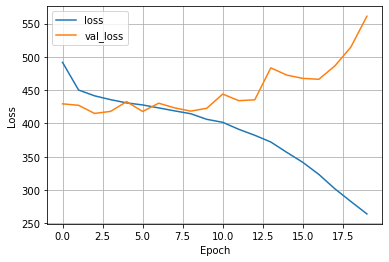

In [ ]:
# Part of code from: https://www.tensorflow.org/tutorials/keras/regression

# Train our model
history = image_NN.fit(train_imgs_array, y_train, batch_size=20, epochs=20, validation_split=.1)

# Store loss during training in DataFrame
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

def plot_loss(history):
    """
    Plot loss during epochs of training a neural network.
    """
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

plot_loss(history)

# See how the model scored
loss = image_NN.evaluate(test_imgs_array, y_test)

# Print to 3 decimals
print(f'Test loss: {loss:.3}')

Epoch 1/20
310/310 [==============================] - 14s 20ms/step - loss: 0.1233 - root_mean_squared_error: 0.3511 - val_loss: 0.1108 - val_root_mean_squared_error: 0.3329
Epoch 2/20
310/310 [==============================] - 6s 18ms/step - loss: 0.0441 - root_mean_squared_error: 0.2100 - val_loss: 0.1207 - val_root_mean_squared_error: 0.3474
Epoch 3/20
310/310 [==============================] - 6s 18ms/step - loss: 0.0429 - root_mean_squared_error: 0.2070 - val_loss: 0.1179 - val_root_mean_squared_error: 0.3434
Epoch 4/20
310/310 [==============================] - 6s 18ms/step - loss: 0.0411 - root_mean_squared_error: 0.2028 - val_loss: 0.1280 - val_root_mean_squared_error: 0.3578
Epoch 5/20
310/310 [==============================] - 5s 18ms/step - loss: 0.0390 - root_mean_squared_error: 0.1974 - val_loss: 0.1068 - val_root_mean_squared_error: 0.3268
Epoch 6/20
310/310 [==============================] - 6s 18ms/step - loss: 0.0369 - root_mean_squared_error: 0.1921 - val_loss: 0.1183

KeyError: ignored

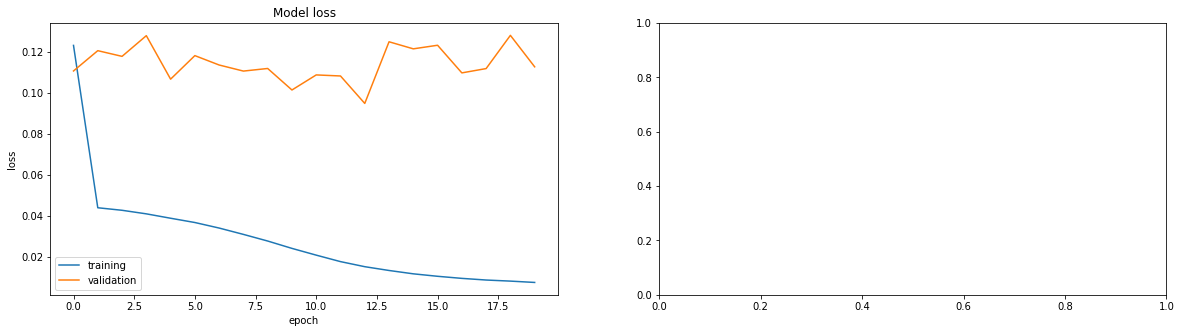

In [17]:


def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)
    
    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', tf.keras.metrics.RootMeanSquaredError()]):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()
    
    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")
    
train_and_evaluate(image_NN, train_imgs_array, y_train, test_imgs_array, y_test,
                  preprocess = {'featurewise_center': True, 'featurewise_std_normalization': True})
